# Introduction
This notebook is a part of the scientific data analysis I did between 2018 and 2019 at Dr. Gorostiza's laboratory, the Institute of Bioengineering for Catalonia.

The purpose of creating this Python code was to facilitate data retrieval, concatenation, visualization and analysis at once in a cost-free software.

The csv file presented in this notebook is one of the experimental results from a research project where I participated as co-author. More details about the project and data can be added in the future once the study becomes available to the public.

# 1. Plot the traces

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import data files (electrophysiology data acquired by HEKA Elektronik's hardware & software)
filenames = sorted(glob.glob('*.csv')) # list all csv files in ascending order
filenames = filenames[:-1]
filenames

['20190725_c2_r06.csv',
 '20190725_c2_r07.csv',
 '20190725_c2_r08.csv',
 '20190725_c2_r09.csv',
 '20190725_c2_r10.csv',
 '20190725_c2_r11.csv',
 '20190725_c2_r13.csv',
 '20190725_c2_r14.csv',
 '20190725_c2_r15.csv']

In [3]:
# Function to retrieve the traces (1 trace = 3 files in series)
def get_traces(start, end):
    # Select subset of filenames to concatenate together
    files_to_read = filenames[start:end]
    
    # Initialize the result dataframe
    df_concat = pd.DataFrame()
    
    # Concatenate the selected files
    for i in range(len(files_to_read)):
        df = pd.read_csv(files_to_read[i],
                         names=['membrane potential(mV)'],
                         index_col=0, header=0, delimiter=',')
        df.loc[:] *= 1000 # multiply 1000 to print the result in mV
        df_concat = df_concat.append(df)
    
    # Reindex the concatenated data
    time=np.arange(0, 180, 0.00005) # interval = acquisition rate (in sec)
    df_concat.index=time
    
    return df_concat

In [4]:
# Get traces from the files
first_trace = get_traces(0,3)
second_trace = get_traces(3,6)
third_trace = get_traces(6,9)

print(len(first_trace))
print(len(second_trace))
print(len(third_trace))

3600000
3600000
3600000


In [5]:
first_trace.head()

,membrane potential(mV)
0.00000,-26.5974
0.00005,-26.2845
0.00010,-27.1293
0.00015,-26.6287
0.00020,-25.9715


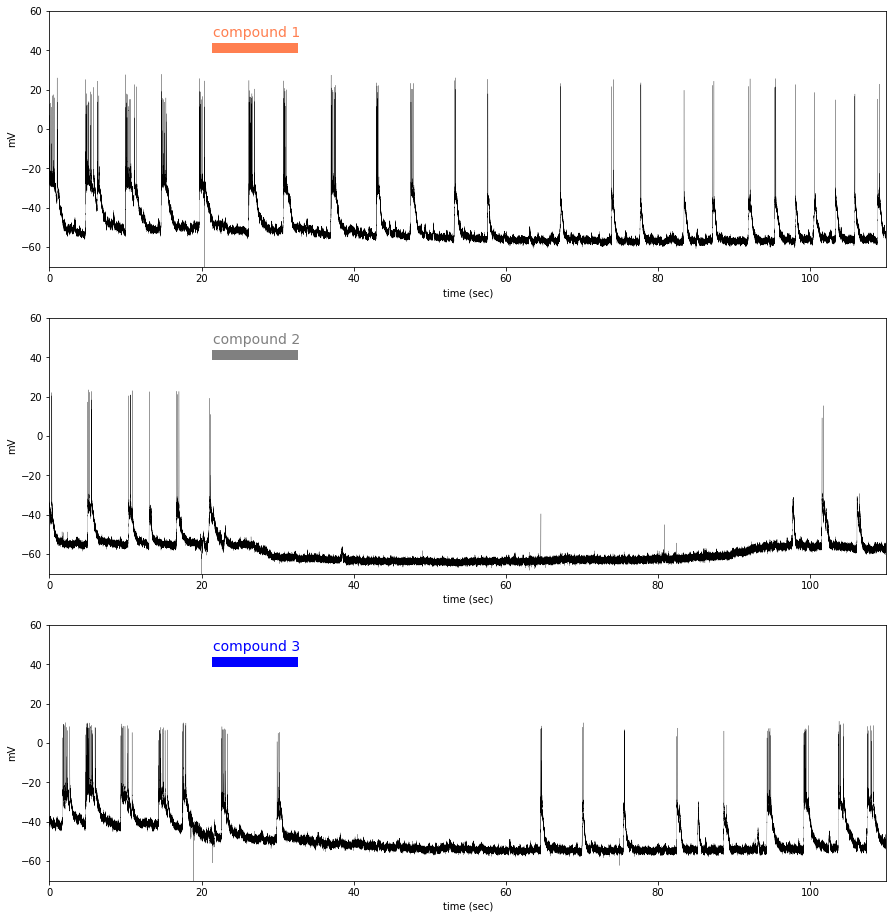

In [6]:
# Plot the traces
fig,ax= plt.subplots(3, 1, figsize=(15,16))

traces = [first_trace, second_trace, third_trace]
colors = ['coral', 'gray', 'blue']

for i, trace in enumerate(traces):
    trace.plot(ax=ax[i], legend=None,
               color='black',linewidth=0.2,
               ylim=(-70,60), xlim=(0,110),
               xlabel='time (sec)', ylabel='mV')
    
    # Indicate the duration of application for each compound
    start = 20 # application started
    end = 30 # application ended
    level = 41 # where to show an application bar (in y)
    
    ax[i].plot([start, end], [level, level], colors[i], linewidth=10) # duration of application
    ax[i].text(21.5, 47, f'compound {i+1}', color=colors[i], size=14) # label for compounds

plt.show()

# 2. Detect peaks and get firing rates

In [7]:
# Import libraries for peak detection:
# 1. find_peaks: finds all local maxima by comparison of neighboring values
# 2. medfilt: median filter
from scipy.signal import find_peaks, medfilt

# of peaks within window: 6


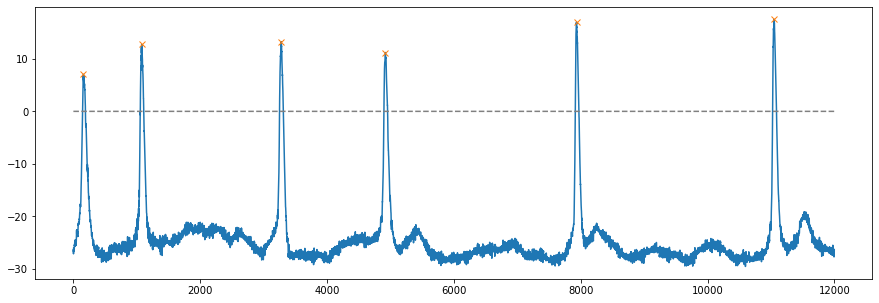

In [8]:
# Example peak detection
# Prepare input as 1-D array
val = traces[0]['membrane potential(mV)'].values[:12000]

# Find peaks
peaks, _ = find_peaks(val, height=0, prominence=2) # peaks: indices of peaks
print(f'# of peaks within window: {len(peaks)}')

# Apply a median filter to reduce noise
medfilt(val, kernel_size=39)

# Plot the peaks and threshold line on top of the trace
plt.figure(figsize=(15,5))
plt.plot(val)  # trace
plt.plot(peaks, val[peaks], "x")  # peaks
plt.plot(np.zeros_like(val), "--", color="gray")  # height
plt.show()

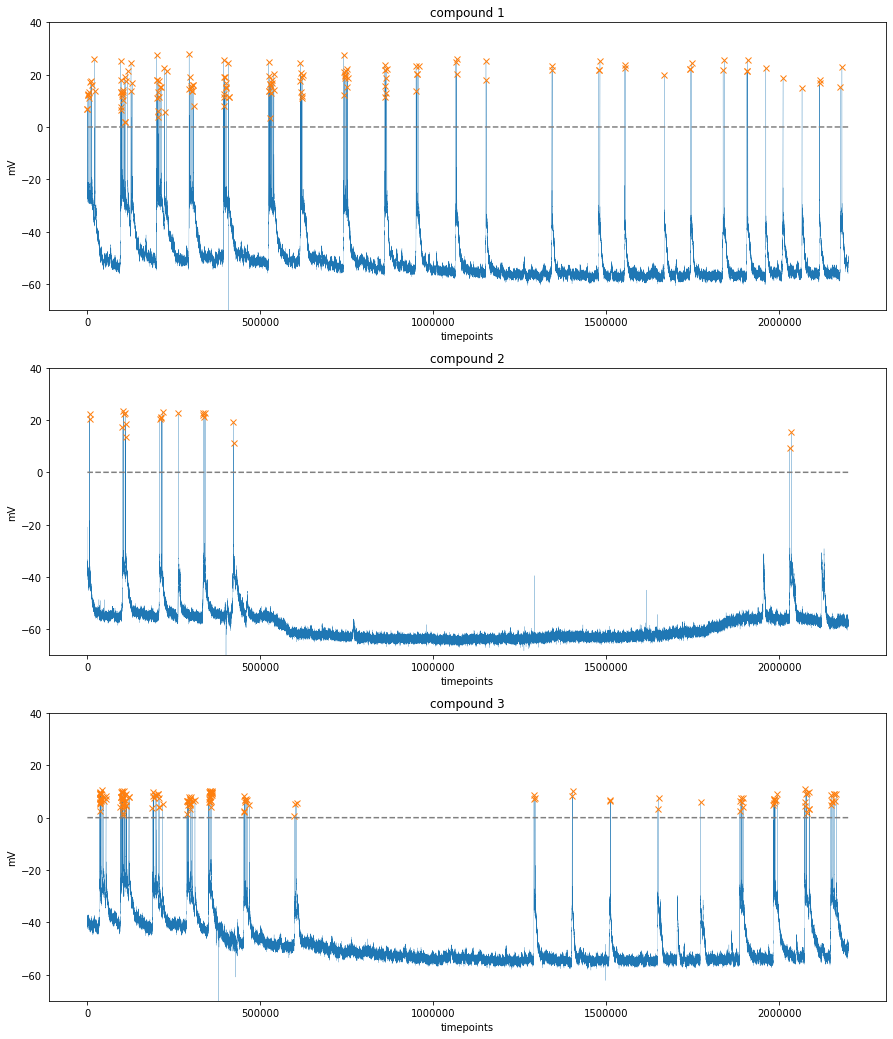

In [9]:
# Detect peaks from all three traces and plot the result
fig,ax= plt.subplots(3, 1, figsize=(15,18))
plt.subplots_adjust(hspace=.2)

for i, trace in enumerate(traces):
    # Prepare input as 1-D array
    val = traces[i]['membrane potential(mV)'].values[:2200000]

    # Find peaks
    peaks, _ = find_peaks(val, height=0, prominence=1)
    
    # Apply a median filter to reduce noise
    medfilt(val, kernel_size=39)
    
    # Plot the peaks and threshold line on top of the trace
    ax[i].plot(val, linewidth=0.2)  # trace
    ax[i].plot(peaks, val[peaks], "x")  # peaks
    ax[i].plot(np.zeros_like(val), "--", color="gray")  # height
    ax[i].set_ylim(-70,40)
    ax[i].set_xlabel('timepoints')
    ax[i].set_ylabel('mV')
    ax[i].set_title(f'compound {i+1}')

plt.show()

In [126]:
# Count the peaks by every 20000 timepoints in x-axis (= 1 seconds)
bins = np.arange(0,2400000,20000)
peak_ranges = pd.DataFrame()
peak_ranges['ranges'] = pd.cut(peaks, bins=bins)

# Count peaks per ranges
counted = peak_ranges.value_counts(sort=False)
counted[:10]

ranges          
(0, 20000]          0
(20000, 40000]      4
(40000, 60000]      4
(60000, 80000]      0
(80000, 100000]     6
(100000, 120000]    9
(120000, 140000]    2
(140000, 160000]    0
(160000, 180000]    0
(180000, 200000]    6
dtype: int64

In [127]:
# Define the frequency
freq = 10

# Aggregate (sum) peak counts for every 10 seconds
counted = pd.DataFrame(counted.values, columns=['counted'])
aggregated = counted.groupby(counted.index // freq).sum()

# New index (indicate every 10 seconds)
new_index = np.arange(0,120,freq)
aggregated.index = new_index
aggregated.head()

,counted
0,31
10,21
20,8
30,2
40,0


In [128]:
# Normalize to the baseline(first 10 seconds)
baseline = aggregated.loc[0].values
normalized = aggregated / baseline
normalized.head()

,counted
0,1.000000
10,0.677419
20,0.258065
30,0.064516
40,0.000000


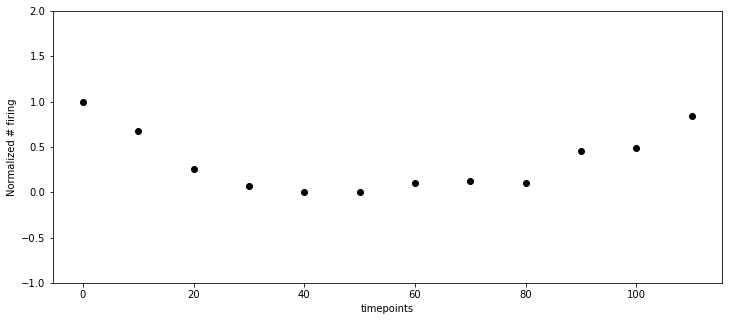

In [129]:
plt.figure(figsize=(12,5))

plt.scatter(new_index, normalized, c='k', marker='o')
plt.ylim(-1,2)
plt.ylabel('Normalized # firing')
plt.xlabel('timepoints')
plt.show()

In [130]:
# Iteraterate the above process to all three traces
result = pd.DataFrame()

for i, trace in enumerate(traces):
    # Prepare input as 1-D array
    val = traces[i]['membrane potential(mV)'].values[:2400000]

    # Find peaks
    peaks, _ = find_peaks(val, height=0, prominence=2)
    
    # Gather peaks per every 20000 points (= 1 seconds)
    peak_ranges = pd.DataFrame()
    peak_ranges['ranges'] = pd.cut(peaks, bins=bins)
    
    # Count peaks per ranges
    counted = peak_ranges.value_counts(sort=False)
    
    # Aggregate (sum) peak counts for every 10 seconds
    counted = pd.DataFrame(counted.values, columns=[f'compound {i+1}'])
    aggregated = counted.groupby(counted.index // freq).sum()

    # Normalize to the baseline(first 10 seconds)
    baseline = aggregated.loc[0].values
    normalized = aggregated / baseline
    
    # Append the result to 
    result = pd.concat([result, normalized], axis=1)
    
result.index = new_index
result.head()

,compound 1,compound 2,compound 3
0,1.000000,1.00,1.000000
10,1.153846,1.00,0.677419
20,0.653846,0.25,0.258065
30,0.615385,0.00,0.064516
40,0.461538,0.00,0.000000


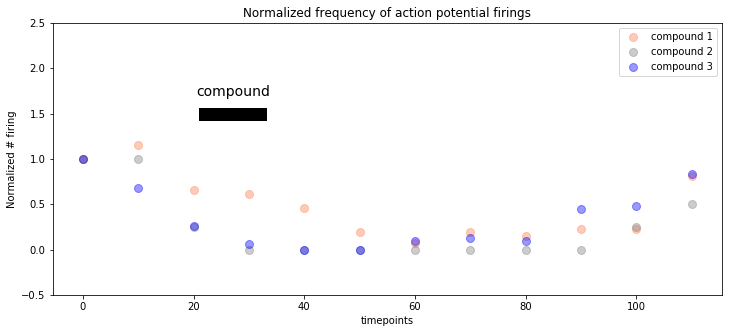

In [131]:
# Plot the normalized frequency
result.plot(figsize=(12,5), marker='o', markersize=8, alpha=.4, linewidth=0, color=colors)
plt.ylim(-0.5,2.5)
plt.title('Normalized frequency of action potential firings')
plt.xlabel('timepoints')
plt.ylabel('Normalized # firing')
plt.plot([start, end], [1.5, 1.5], color='k', linewidth=13) # duration of application
plt.text(20.5, 1.7, 'compound', size=14)

plt.show()

* Note:
    
Compound 1-3 are expected to reduce neuronal excitability to different extent. The result seems to support our hypothesis, since the application of the compounds abolished the action potentials and decreased the firing frequency. In the next step, we will run statistics on a collection of data (more # of data acquired in the same condition, different date) to evaluate the significance of these compounds.

# 3. Statistics